In [1]:
%matplotlib inline
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.backend.tensorflow_backend import set_session

import tensorflow as tf

import numpy as np

from collections import namedtuple
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.measure import compare_psnr
from skimage.util import view_as_windows
from skimage.data import imread
from skimage import img_as_float

from sklearn.model_selection import train_test_split

from skimage import color, io

import scipy.misc

import os
from os.path import isdir
from patchify import patchify, unpatchify

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def mean_psnr(origin, corrupted, noise):
    psnrs = []
    for i in range(len(noise)):  
        psnr = compare_psnr(origin[i], (corrupted[i] - noise[i]).reshape(512,512))
        psnrs.append(psnr)
    return np.mean(psnrs)

In [4]:
def one_one_correspondence( file_list_1,file_list_2 ):
    
    for index1, file1 in enumerate(file_list_1):
        file1 = file1.split('_')
        #print (file1)
        for index2, file2 in enumerate(file_list_2):
            file2 = file2.split('.')
            file2_compare_tag = file2[0].split('_')
            #print (file2)
            if file1[0]==file2_compare_tag[0]:
                temp = file_list_2[index2]
                file_list_2[index2] = file_list_2[index1]
                file_list_2[index1] = temp
    return file_list_1, file_list_2

In [5]:
def read_image_in_folder( folder_name_1, folder_name_2 ):
    I1 = []
    I2 = []
    images_from_folder1 = os.listdir( folder_name_1 )
    images_from_folder2 = os.listdir( folder_name_2 )
    #[images_from_folder1,images_from_folder2] = one_one_correspondence( images_from_folder1,images_from_folder2 )
    for image in images_from_folder1:
        if image != ".DS_Store" and not isdir(image):
            I1.append(mpimg.imread(folder_name_1 + image))
    for image in images_from_folder2:
        if image != ".DS_Store" and not isdir(image):
            I2.append(mpimg.imread(folder_name_2 + image))
    return np.array(I1), np.array(I2)

In [6]:
def crop_to_patches( dataset, patch_size ):
    # repeatition
    result = []
    step = 11
    for data in dataset: 
        data = img_as_float(data)
        cropped = view_as_windows(data, (patch_size,patch_size), step=step)
        result.append(cropped.reshape(-1, patch_size, patch_size))
    return np.array(result) 

In [7]:
def get_noise( clean_images, distorted_images ):
    assert len(clean_images) == len(distorted_images)
    
    noises = []
    for idx in range(len(clean_images)):
        new = img_as_float(distorted_images[idx]) - img_as_float(clean_images[idx])
        #print(n)
        noises.append(new)
    return np.array(noises)

In [8]:
DataSet = namedtuple("DataSet", ["origin", "corrupted", "noise", "corrupted_patches", "noise_patches"])

# New dataset

In [9]:
def generate_noisy_images( read_folder_name, save_folder_name ):
    for image_name in os.listdir( read_folder_name ):
        img = img_as_float(io.imread(read_folder_name + image_name))
        noisy_img = img + np.random.normal(0,0.06,img.shape)
        scipy.misc.imsave((save_folder_name + image_name), noisy_img)
        
def im2gray( read_folder_name, save_folder_name ):
    image_list = os.listdir( read_folder_name )
    image_shape = color.rgb2gray(img_as_float(io.imread(read_folder_name + image_list[0]))).shape
    print(image_list[0])
    #first image shape - used for rotate
    for image_name in image_list:
        if image_name != ".ipynb_checkpoints":
            img = color.rgb2gray(img_as_float(io.imread(read_folder_name + image_name)))
            if image_shape != img.shape:
                img = np.rot90(img)
            scipy.misc.imsave((save_folder_name + image_name), img)

In [10]:
im2gray("images/train/", "images/train_gray/")
im2gray("images/test/", "images/test_gray/")
generate_noisy_images("images/train_gray/", "images/train_noise/")
generate_noisy_images("images/test_gray/", "images/test_noise/")

8143.jpg


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


101085.jpg


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [12]:
new_train_dataset.corrupted_patches.shape

(200, 1066, 40, 40)

In [11]:
patch_size = 40

new_train_dataset = read_image_in_folder( "images/train_gray/","images/train_noise/" )
new_train_noise = get_noise(new_train_dataset[0], new_train_dataset[1])
new_train_dataset = DataSet(new_train_dataset[0], new_train_dataset[1], 
                            new_train_noise,
                            crop_to_patches( new_train_dataset[1], patch_size ),
                            crop_to_patches( new_train_noise, patch_size )
)

new_test_dataset = read_image_in_folder( "images/test_gray/","images/test_noise/" )
new_test_noise = get_noise(new_test_dataset[0], new_test_dataset[1])
new_test_dataset = DataSet(new_test_dataset[0], new_test_dataset[1], 
                           new_test_noise,
                           crop_to_patches( new_test_dataset[1], patch_size ),
                           crop_to_patches( new_test_noise, patch_size )
)

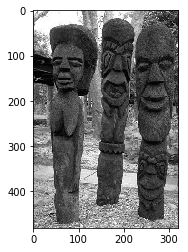

In [82]:
plt.imshow(new_test_dataset.origin[0], cmap="gray")

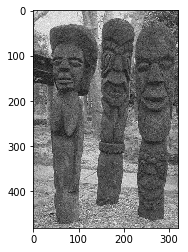

In [81]:
plt.imshow(new_test_dataset.corrupted[0], cmap="gray")

In [30]:
patchify(new_train_dataset.origin[0], (40,40), step=11).shape

(26, 41, 40, 40)

In [382]:
# shape_val = 35

# X = natural_dataset.corrupted_patches + syn_dataset.corrupted_patches
# Y = natural_dataset.noise_patches + syn_dataset.noise_patches

In [383]:
# trainX, testX, trainY, testY = train_test_split(X, Y, shuffle=True)

In [13]:
trainX = new_train_dataset.corrupted_patches
testX = new_test_dataset.corrupted_patches
trainY = new_train_dataset.noise_patches
testY = new_test_dataset.noise_patches

In [14]:
shape_val = 40
trainX = np.reshape(trainX, (-1, shape_val, shape_val, 1))
testX = np.reshape(testX, (-1, shape_val, shape_val, 1))
trainY = np.reshape(trainY, (-1, shape_val, shape_val, 1))
testY = np.reshape(testY, (-1, shape_val, shape_val, 1))

# Defining network structure

In [ ]:
input_img = Input(shape=(shape_val, shape_val, 1))
depth = 17

layers = last_layer(middle_layers(depth - 2, first_layer(input_img)))

autoencoder = Model(input_img, layers)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

autoencoder.fit(x=trainX,
            y=trainY,
            epochs=50,
            batch_size=128,
            shuffle=True,
            verbose=1,
            validation_data=(testX, testY),
            callbacks=[TensorBoard(log_dir='logs', histogram_freq=0, write_graph=False)]
           )


Train on 213200 samples, validate on 106600 samples
Epoch 1/50
213200/213200 [==============================] - 1301s 6ms/step - loss: 0.0175 - val_loss: 0.0051
Epoch 2/50
213200/213200 [==============================] - 1299s 6ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 3/50
 76928/213200 [=========>....................] - ETA: 11:52 - loss: 0.0042

In [20]:
autoencoder.save('my_model_patch_new_data.h5')

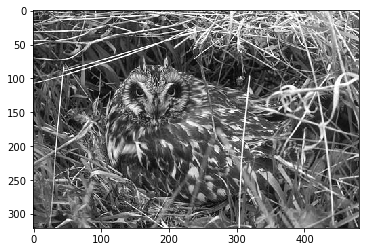

In [38]:
plt.imshow(new_train_dataset.origin[0], cmap="gray")

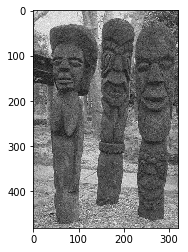

In [55]:
plt.imshow(new_test_dataset.corrupted[0], cmap="gray")

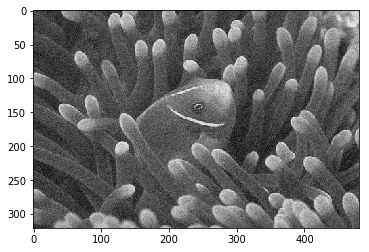

In [76]:
plt.imshow(np.rot90(new_test_dataset.corrupted[13]), cmap="gray")

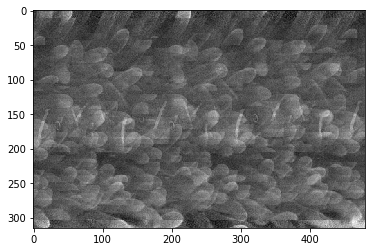

In [77]:
plt.imshow(unpatchify(new_test_dataset.corrupted_patches[13].reshape(-1,40,40)[:1066].reshape(26, 41, 40,40), step=11), cmap="gray")

In [21]:
testY.reshape

array([[[[-0.11764706],
         [-0.15686275],
         [-0.16862745],
         ..., 
         [-0.03529412],
         [-0.03529412],
         [-0.09019608]],

        [[-0.04313725],
         [-0.09411765],
         [-0.10196078],
         ..., 
         [-0.05882353],
         [-0.11372549],
         [-0.15294118]],

        [[-0.0745098 ],
         [-0.15686275],
         [-0.16078431],
         ..., 
         [-0.16862745],
         [-0.28235294],
         [-0.07843137]],

        ..., 
        [[-0.01176471],
         [-0.09803922],
         [-0.16862745],
         ..., 
         [-0.12156863],
         [-0.12941176],
         [-0.12941176]],

        [[-0.00392157],
         [-0.05098039],
         [-0.10588235],
         ..., 
         [-0.0745098 ],
         [-0.0627451 ],
         [-0.12156863]],

        [[-0.05490196],
         [-0.01176471],
         [-0.05882353],
         ..., 
         [-0.1254902 ],
         [-0.14509804],
         [-0.12941176]]],


       [[[-0.20784

In [71]:
#autoencoder = load_model('my_model_patch_2.h5')

In [72]:
from patchify import patchify, unpatchify

In [122]:
def deal_patch( images ):
    result = []
    for i in images:
        patches = patchify(i, (40,40), step=2)
        patches = patches.reshape(237*237, 40, 40, 1)#237 correspond step=2
        result.append(patches)
    return result

In [123]:
clean = deal_patch(natural_dataset.origin)
dirty = deal_patch(natural_dataset.corrupted)

In [124]:
predY = []
for patches in dirty:
    temp = autoencoder.predict(patches)
    temp = temp.reshape(237,237,40,40)
    predY.append(temp)

In [126]:
noise=[]
for y in predY:
    a = unpatchify(y, (512,512))
    noise.append(a)

In [134]:
patches = patchify(natural_dataset.corrupted[7], (40,40), step=5)

In [135]:
patches.shape

(95, 95, 40, 40)

In [137]:
patches = patchify(natural_dataset.corrupted[7], (40,40), step=5)
patches = patches.reshape(95*95, 40, 40, 1)#95 correspond step=5
temp = autoencoder.predict(patches)
temp = temp.reshape(95,95,40,40)
a = unpatchify(temp, (510,510))

In [133]:
mean_psnr(natural_dataset.origin, natural_dataset.corrupted, noise)

20.827132889054479

In [106]:
compare_psnr(natural_dataset.origin[7], natural_dataset.corrupted[7])

23.509597831153837

In [141]:
compare_psnr(natural_dataset.origin[7][:510,:510],
             np.array(natural_dataset.corrupted[7][:510,:510]) - np.array(a))

20.577903868396731

In [144]:
from sklearn.metrics import mean_squared_error

In [145]:
mean_squared_error(natural_dataset.origin[7], natural_dataset.corrupted[7])

0.0044569746

In [146]:
mean_squared_error(natural_dataset.origin[7][:510,:510],
             np.array(natural_dataset.corrupted[7][:510,:510]) - np.array(a))

0.0087540625